# Multimodal House Price Prediction (Images + Tabular Data)

In this project, we build a **multimodal machine learning model** to predict house prices using:

- **Tabular features** (e.g., number of beds, baths, square footage)
- **House images** (exterior visuals)
  
This approach leverages both numerical and visual information to make more accurate predictions. We'll use the **SoCal Housing Dataset** that includes over 15,000 house images along with metadata.



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## Load the Dataset

Load the SoCal dataset, which includes:
- `socal2.csv`: Contains tabular features (bed, bath, sqft, price, etc.)
- `socal_pics/`: Directory with house images (named 0.jpg, 1.jpg, ..., etc.)

Construct a full dataframe with image paths and tabular data.


In [ ]:
csv_path = '/kaggle/input/house-prices-and-images-socal/socal2.csv'
img_dir = '/kaggle/input/house-prices-and-images-socal/socal2/socal_pics'

df = pd.read_csv(csv_path)
df.head()


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


## Preprocess Images and Tabular Data

In [8]:
def load_image(image_id, directory=img_dir, size=(224, 224)):
    path = os.path.join(directory, f"{image_id}.jpg")
    try:
        img = Image.open(path).convert('RGB').resize(size)
        return np.array(img)
    except:
        return None

# Load image arrays
df['image_array'] = df['image_id'].apply(lambda x: load_image(x))

# Drop rows with missing images
df = df[df['image_array'].notna()]
df.reset_index(drop=True, inplace=True)


In [ ]:
# Define input features and target
tabular_cols = ['bed', 'bath', 'sqft']
target_col = 'price'

# Drop missing values
df = df.dropna(subset=tabular_cols + [target_col])

# Image array
X_img = np.stack(df['image_array'].values)
X_img = preprocess_input(X_img)

# Tabular array
X_tab = df[tabular_cols].values
y = df[target_col].values

scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab)

X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(X_tab, X_img, y, test_size=0.2, random_state=42)


## The Multimodal Model

We build a hybrid deep learning model that:
- Uses **EfficientNetB0** for image feature extraction
- A simple **Dense Neural Network** for tabular inputs
- Combines both through concatenation for final prediction

This approach allows the model to learn from both numeric and visual inputs jointly.


In [10]:
# Image branch
img_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')(img_input)
img_features = Dense(128, activation='relu')(base_model)

# Tabular branch
tab_input = Input(shape=(X_tab.shape[1],), name="tabular_input")
tab_features = Dense(64, activation='relu')(tab_input)

# Fusion
combined = Concatenate()([img_features, tab_features])
x = Dense(64, activation='relu')(combined)
output = Dense(1, name="output")(x)

# Build model
model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


I0000 00:00:1752966574.291961      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752966574.292776      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 1280)      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        256 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,226,212 (16.12 MB)

 Trainable params: 4,184,189 (15.96 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Train the Model

Train the model using the `mean_squared_error` loss and the Adam optimizer for 25 epochs.

**Note: You can use more epochs to train the model**


In [14]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=32
)

Epoch 1/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - loss: 63248580608.0000 - mae: 188366.2500 - val_loss: 96967704576.0000 - val_mae: 226281.4531
Epoch 2/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 50632433664.0000 - mae: 168494.0312 - val_loss: 103259160576.0000 - val_mae: 224669.9375
Epoch 3/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - loss: 38468558848.0000 - mae: 150213.6562 - val_loss: 99122356224.0000 - val_mae: 221262.6875
Epoch 4/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - loss: 32060653568.0000 - mae: 136754.0156 - val_loss: 97278967808.0000 - val_mae: 230696.7344
Epoch 5/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - loss: 25175250944.0000 - mae: 123083.4922 - val_loss: 93390331904.0000 - val_mae: 210433.5312
Epoch 6/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - loss: 20784379904.0000 - mae: 110130.0000 - val_loss: 95344525312.0000 - val_mae: 209629.0469
Epoch 7/25
349/349 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - loss: 18619297792.0000 - mae: 104267

## Evaluate Model Performance

We calculate key regression metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)


In [ ]:
y_pred = model.predict([X_img_test, X_tab_test])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
MAE: 212205.77
RMSE: 300856.37


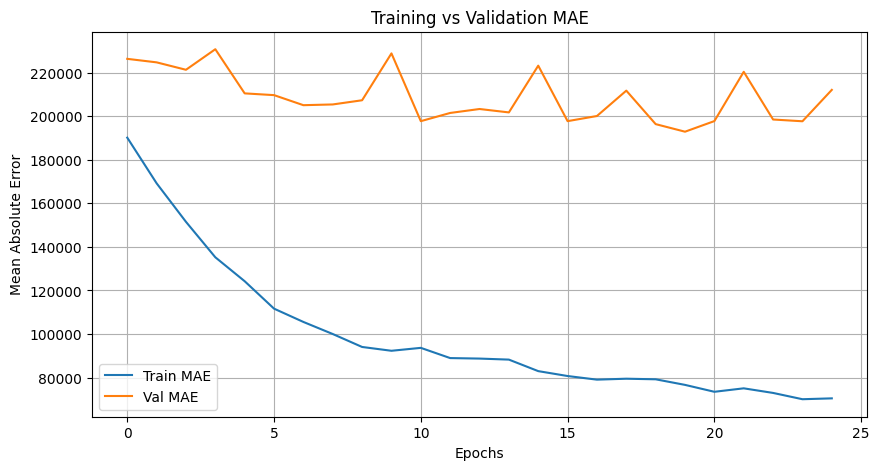

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)
plt.show()
